# 고객 재구매/이탈 예측 분석 (Online Retail Dataset)

이 노트북은 **문제 + 정답/해설 버전**입니다.
원래 강의안(프로모션 효율 예측 KNN/SVM)의 구조를 그대로 따라가되,
데이터는 UCI Online Retail Dataset(`Online Retail.xlsx`)으로 바꿔서 진행합니다.

목표:
1. 거래 데이터를 고객 단위 특징으로 요약한다.
2. 고객을 '유지(1)/이탈(0)'으로 라벨링한다.
3. KNN과 SVM으로 분류 성능을 비교한다.


## 1. 라이브러리 불러오기
문제 1. 필요한 라이브러리를 임포트하라.

In [1]:
# 정답 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE


## 2. 데이터 로드 및 기본 확인
문제 2~5. 데이터를 불러와 구조를 확인하고 결측치와 국가 비중을 살펴보라.

In [2]:
# 정답 코드
# (경로는 ./data/Online Retail.xlsx 라고 가정)
df = pd.read_excel('./data/Online Retail.xlsx')

# 기본 구조 확인
display(df.head())
print('--- columns ---')
print(df.columns)
print('--- info ---')
df.info()

# 결측치 확인
na_cnt = df.isna().sum().sort_values(ascending=False)
print('--- NA count ---')
print(na_cnt.head())
# 해설: CustomerID가 특히 비어있는 행이 많다. 익명 방문/게스트 구매 흔적.

# 영국 비중
uk_ratio = (df['Country'] == 'United Kingdom').mean() * 100
print(f"영국 거래 비율: {uk_ratio:.2f}%")
# 해설: Online Retail 데이터는 UK가 대부분이라 편향돼 있음.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


--- columns ---
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
--- info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
--- NA count ---
CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
dtype: in

## 3. 전처리 (취소/반품 제거)
문제 6~8. 음수/0 수량 또는 단가 제거, 취소 인보이스 제거, TotalPrice 추가, InvoiceDate datetime 변환.

In [3]:
# 정답 코드
# 음수/0 제거
clean_df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

# 취소 인보이스 제거 (InvoiceNo starting with 'C')
clean_df = clean_df[~clean_df['InvoiceNo'].astype(str).str.startswith('C')].copy()

# 총 금액
clean_df['TotalPrice'] = clean_df['Quantity'] * clean_df['UnitPrice']

# 날짜형 변환
clean_df['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate'])

print(clean_df.head())
print(clean_df[['Quantity','UnitPrice','TotalPrice','InvoiceDate']].head())
# 해설: 이제 clean_df는 실제 유효 판매만 남게 됨. 회수/취소 제거로 label 더 안정화.

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
   Quantity  UnitPrice  TotalPrice         InvoiceDate
0         6       2.55       15.30 2010-12-01 08:26:00
1      

## 4. 고객 단위 요약 (RFM 유사 특징)
문제 9. CustomerID 단위로 구매 횟수, 총액, 평균액, 마지막 구매일을 만든다.

In [4]:
# 정답 코드
customer_df = clean_df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',          # 구매 횟수
    'TotalPrice': ['sum', 'mean'], # 총 사용액 / 평균 사용액
    'InvoiceDate': 'max'           # 마지막 구매일
})
customer_df.columns = ['purchase_count','total_spent','avg_spent','last_purchase']

display(customer_df.head())
print(customer_df.describe())
# 해설: 이제 row=고객, col=요약 특성. 이후 ML의 입력 X로 사용 예정.

,purchase_count,total_spent,avg_spent,last_purchase
CustomerID,,,,
12346.0,1,77183.60,77183.600000,2011-01-18 10:01:00
12347.0,182,4310.00,23.681319,2011-12-07 15:52:00
12348.0,31,1797.24,57.975484,2011-09-25 13:13:00
12349.0,73,1757.55,24.076027,2011-11-21 09:51:00
12350.0,17,334.40,19.670588,2011-02-02 16:01:00


       purchase_count    total_spent     avg_spent  \
count     4338.000000    4338.000000   4338.000000   
mean        91.720609    2054.266460     68.350506   
min          1.000000       3.750000      2.101286   
25%         17.000000     307.415000     12.365367   
50%         41.000000     674.485000     17.723119   
75%        100.000000    1661.740000     24.858417   
max       7847.000000  280206.020000  77183.600000   
std        228.785094    8989.230441   1467.918896   

                       last_purchase  
count                           4338  
mean   2011-09-08 11:38:59.045643008  
min              2010-12-01 09:53:00  
25%              2011-07-20 19:18:00  
50%              2011-10-20 10:40:30  
75%              2011-11-22 11:05:45  
max              2011-12-09 12:50:00  
std                              NaN  


## 5. Recency 와 churn_flag 생성
문제 10~13. 마지막 구매일 대비 며칠 지났는지(recency_days)를 구하고,
recency_days < 180이면 유지(1), 아니면 이탈(0)이라는 라벨을 만든다. 결측은 제거.

In [5]:
# 정답 코드
latest_date = clean_df['InvoiceDate'].max()
customer_df['recency_days'] = (latest_date - customer_df['last_purchase']).dt.days

# 단순 라벨링 기준: 180일 이내면 active / 그 이상이면 inactive
customer_df['churn_flag'] = (customer_df['recency_days'] < 180).astype(int)

# CustomerID가 NaN이거나 계산 불가한 행 제거 (보통 CustomerID NaN 행은 groupby에서 제외되지만 안전하게)
customer_df = customer_df.dropna(subset=['purchase_count','total_spent','avg_spent','recency_days','churn_flag'])

print(customer_df[['purchase_count','total_spent','avg_spent','recency_days','churn_flag']].head())
print(customer_df['churn_flag'].value_counts())
# 해설: churn_flag의 불균형을 확인한다. 보통 유지(1)가 적거나 많을 수 있음.

            purchase_count  total_spent     avg_spent  recency_days  \
CustomerID                                                            
12346.0                  1     77183.60  77183.600000           325   
12347.0                182      4310.00     23.681319             1   
12348.0                 31      1797.24     57.975484            74   
12349.0                 73      1757.55     24.076027            18   
12350.0                 17       334.40     19.670588           309   

            churn_flag  
CustomerID              
12346.0              0  
12347.0              1  
12348.0              1  
12349.0              1  
12350.0              0  
churn_flag
1    3478
0     860
Name: count, dtype: int64


## 6. 특징 분포 시각화
문제 14. 히스토그램으로 주요 수치형 특성을 살펴본다. (원 강의안에서의 histogram 파트 대응)

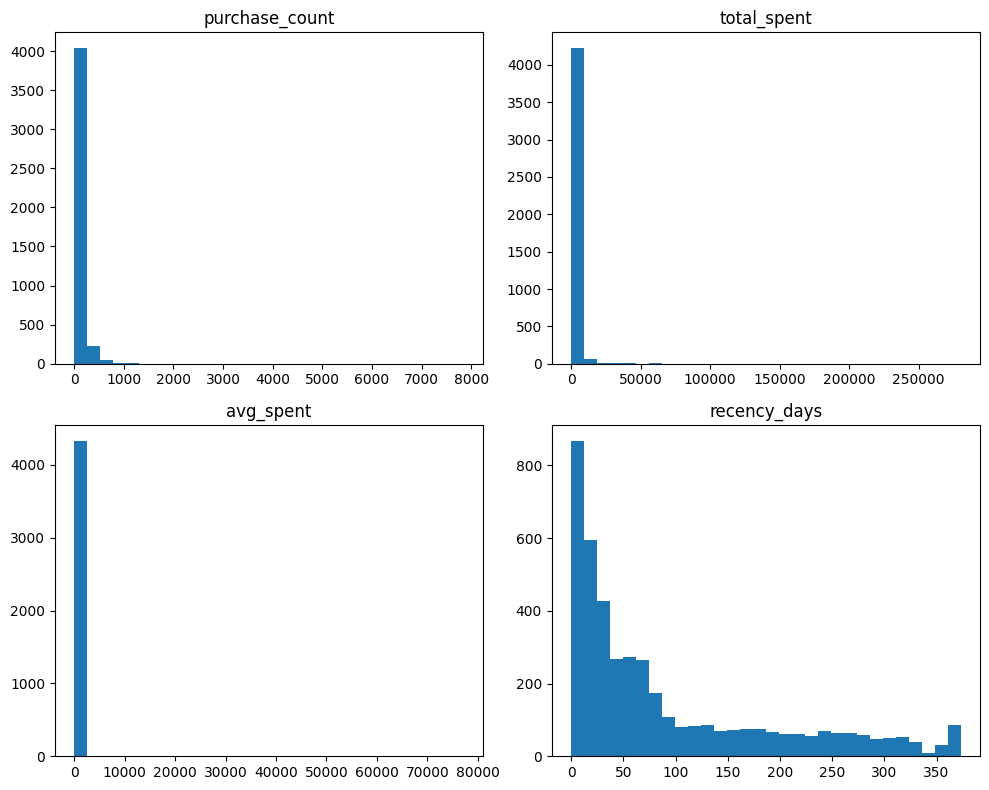

In [6]:
# 정답 코드
cols_to_plot = ['purchase_count','total_spent','avg_spent','recency_days']
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes = axes.ravel()
for ax, col in zip(axes, cols_to_plot):
    ax.hist(customer_df[col], bins=30)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# 해설: 분포를 보면 total_spent나 purchase_count는 치우친 편(우측 꼬리).

## 7. 학습/검증/테스트 분할
문제 15~17. X/y를 만들고 train, valid, test로 나눈다.
원 강의안과 똑같이 두 단계 split을 사용한다.

In [7]:
# 정답 코드
X = customer_df[['recency_days','purchase_count','total_spent','avg_spent']].copy()
y = customer_df['churn_flag'].copy()

# 1차: train vs temp(valid+test)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 2차: temp -> valid vs test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42
)

print('train size:', len(X_train), 'valid size:', len(X_valid), 'test size:', len(X_test))
print('train label dist:\n', y_train.value_counts(normalize=True))
print('valid label dist:\n', y_valid.value_counts(normalize=True))
print('test label dist:\n', y_test.value_counts(normalize=True))
# 해설: stratify=y 로 클래스 비율을 유지하려는 구조이며,
# train / valid / test 각각에 라벨 비율이 비슷해야 한다.

train size: 2602 valid size: 868 test size: 868
train label dist:
 churn_flag
1    0.801691
0    0.198309
Name: proportion, dtype: float64
valid label dist:
 churn_flag
1    0.801843
0    0.198157
Name: proportion, dtype: float64
test label dist:
 churn_flag
1    0.801843
0    0.198157
Name: proportion, dtype: float64


## 8. MinMaxScaler + KNN
문제 18~19. MinMaxScaler로 스케일링 → KNN 학습 → classification_report.
원 강의안의 KNN 파트와 동일한 단계.

=== KNN on VALID ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       172
           1       1.00      1.00      1.00       696

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



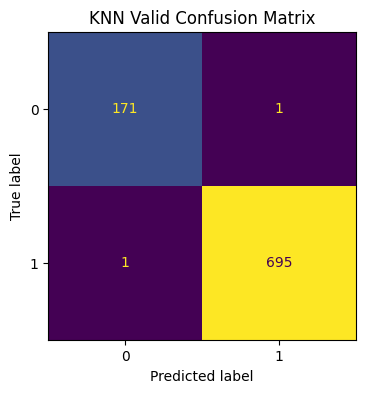

In [8]:
# 정답 코드
mms = MinMaxScaler()
mms.fit(X_train)

mms_X_train = pd.DataFrame(mms.transform(X_train), columns=X_train.columns, index=X_train.index)
mms_X_valid = pd.DataFrame(mms.transform(X_valid), columns=X_train.columns, index=X_valid.index)
mms_X_test  = pd.DataFrame(mms.transform(X_test),  columns=X_train.columns, index=X_test.index)

knn = KNeighborsClassifier()
knn.fit(mms_X_train, y_train)

valid_pred_knn = knn.predict(mms_X_valid)
print('=== KNN on VALID ===')
print(classification_report(y_valid, valid_pred_knn))

# 혼동행렬(선택):
fig, ax = plt.subplots(1,1, figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_valid, valid_pred_knn, ax=ax, colorbar=False)
ax.set_title('KNN Valid Confusion Matrix')
plt.show()

# 해설: classification_report에서 특히 1 클래스(유지 고객)에 대한 recall이 중요.
# 유지 고객을 많이 못 잡으면 마케팅 타겟을 놓치는 셈이고,
# 반대로 precision이 낮으면 엉뚱한 고객에게 마케팅 비용을 낭비.

## 9. KNN 하이퍼파라미터 탐색 (k 값)
문제 20~22. 표본 수 기반으로 k를 추정하고 비교한다.
원 강의안의 `np.sqrt(n)` / `np.log2(n)` 방식 그대로.

In [9]:
# 정답 코드
k_sqrt = int(np.sqrt(len(mms_X_train)))
k_log2 = int(np.log2(len(mms_X_train)))
print('k_sqrt =', k_sqrt, 'k_log2 =', k_log2)

knn_sqrt = KNeighborsClassifier(n_neighbors=k_sqrt)
knn_sqrt.fit(mms_X_train, y_train)
valid_pred_sqrt = knn_sqrt.predict(mms_X_valid)
print('=== KNN k_sqrt VALID ===')
print(classification_report(y_valid, valid_pred_sqrt))

knn_log2 = KNeighborsClassifier(n_neighbors=k_log2)
knn_log2.fit(mms_X_train, y_train)
valid_pred_log2 = knn_log2.predict(mms_X_valid)
print('=== KNN k_log2 VALID ===')
print(classification_report(y_valid, valid_pred_log2))

print('라벨 분포(y_train):')
print(y_train.value_counts())

# 해설:
# - recall(1): 실제 유지 고객(1) 중 모델이 1로 맞춘 비율.
#   -> 이게 낮으면 유지 고객을 제대로 못 찾는 것.
# - precision(1): 모델이 1이라 예측한 고객 중 실제 유지 고객 비율.
#   -> 이게 낮으면 쓸데없이 마케팅 자원을 쏟는 것.


k_sqrt = 51 k_log2 = 11
=== KNN k_sqrt VALID ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       696

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

=== KNN k_log2 VALID ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       172
           1       1.00      1.00      1.00       696

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

라벨 분포(y_train):
churn_flag
1    2086
0     516
Name: count, dtype: int64


## 10. 클래스 불균형 보정 (SMOTE)
문제 23~24. 소수 클래스(예: 유지 고객 또는 이탈 고객 중 적은 쪽)를 증폭한 뒤 KNN을 다시 학습.
원 강의안에서 SMOTENC로 했던 흐름을 SMOTE로 단순화.

In [10]:
# 정답 코드
smote = SMOTE(random_state=42)
smt_X_train, smt_y_train = smote.fit_resample(mms_X_train, y_train)

print('원본 y_train 분포:')
print(y_train.value_counts(normalize=True))
print('SMOTE 이후 y_train 분포:')
print(pd.Series(smt_y_train).value_counts(normalize=True))

# k는 위에서 비교 후 더 나은 쪽을 예시로 사용 (여기서는 k_log2 사용 예)
knn_smote = KNeighborsClassifier(n_neighbors=k_log2)
knn_smote.fit(smt_X_train, smt_y_train)
valid_pred_smote = knn_smote.predict(mms_X_valid)
print('=== KNN w/SMOTE VALID ===')
print(classification_report(y_valid, valid_pred_smote))

# 해설: SMOTE로 클래스 불균형을 줄이면 minority class recall이 올라갈 수 있지만
# precision이 떨어질 수도 있다. 즉 많이 잡지만(리콜↑) 헛발질도 많아짐(정밀도↓).

원본 y_train 분포:
churn_flag
1    0.801691
0    0.198309
Name: proportion, dtype: float64
SMOTE 이후 y_train 분포:
churn_flag
1    0.5
0    0.5
Name: proportion, dtype: float64
=== KNN w/SMOTE VALID ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       172
           1       1.00      1.00      1.00       696

    accuracy                           1.00       868
   macro avg       0.99      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



## 11. SVM 분석 (StandardScaler)
문제 25~27. StandardScaler로 표준화 후 SVM(SVC) 학습, valid/test 평가, KNN과 비교.
원 강의안의 SVM 파트와 같은 구조.

=== SVM VALID ===
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       172
           1       1.00      0.98      0.99       696

    accuracy                           0.98       868
   macro avg       0.96      0.99      0.97       868
weighted avg       0.98      0.98      0.98       868



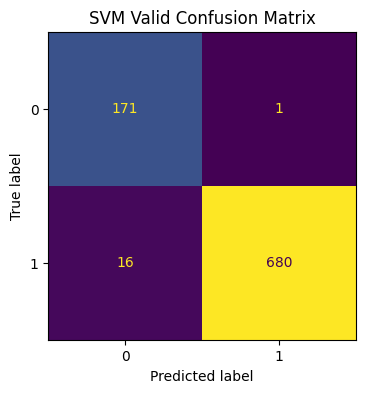

=== SVM TEST ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       172
           1       1.00      0.98      0.99       696

    accuracy                           0.99       868
   macro avg       0.96      0.99      0.98       868
weighted avg       0.99      0.99      0.99       868



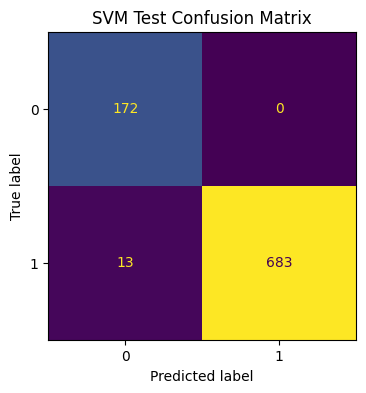

In [11]:
# 정답 코드
ss = StandardScaler()
ss.fit(X_train)

ss_X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns, index=X_train.index)
ss_X_valid = pd.DataFrame(ss.transform(X_valid), columns=X_train.columns, index=X_valid.index)
ss_X_test  = pd.DataFrame(ss.transform(X_test),  columns=X_train.columns, index=X_test.index)

svc = SVC(class_weight='balanced', random_state=42)
svc.fit(ss_X_train, y_train)

valid_pred_svc = svc.predict(ss_X_valid)
test_pred_svc  = svc.predict(ss_X_test)

print('=== SVM VALID ===')
print(classification_report(y_valid, valid_pred_svc))
fig, ax = plt.subplots(1,1, figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_valid, valid_pred_svc, ax=ax, colorbar=False)
ax.set_title('SVM Valid Confusion Matrix')
plt.show()

print('=== SVM TEST ===')
print(classification_report(y_test, test_pred_svc))
fig, ax = plt.subplots(1,1, figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, test_pred_svc, ax=ax, colorbar=False)
ax.set_title('SVM Test Confusion Matrix')
plt.show()

# 해설:
# - class_weight='balanced'를 주면 불균형 라벨에 가중치를 자동으로 줘 minority class를 더 잘 맞추려 함.
# - 일반적으로 SVM(RBF 커널)은 비선형 경계 학습이 가능해서 단순 KNN보다 복잡한 패턴을 더 잘 잡을 수 있다.
# - 최종 비교: 유지(1) 클래스 recall과 precision이 비즈니스적으로 어떤 의미인지 꼭 해석해라.


## 최종 해설 요약
- Online Retail 데이터는 고객별로 RFM 비슷한 지표(purchase_count, total_spent, avg_spent, recency_days)를 만들 수 있다.
- recency_days를 기준으로 churn_flag(유지/이탈)를 라벨링하면 이진분류 문제가 된다.
- KNN은 거리 기반이라 스케일에 민감 → MinMaxScaler 필수.
- K 값은 모델 성능(특히 minority 클래스 recall)에 큰 영향을 준다.
- 클래스 불균형일 경우 SMOTE로 minority를 증폭하면 recall을 끌어올릴 수 있지만 precision은 희생될 수 있다.
- SVM은 비선형 결정경계 + class_weight='balanced'로 불균형에 좀 더 강하며, 종종 KNN보다 전반적인 f1-score가 좋아진다.
- 실제 마케팅/CRM에서는 유지 고객(1)을 잘 잡는 high recall 모델이 중요하지만, precision이 너무 낮으면 쓸데없는 프로모션 비용이 커지므로 두 지표의 트레이드오프를 반드시 같이 본다.
